In [76]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from urllib.parse import urlparse
from tld import get_tld
import os.path
import re

import os

# Paths

In [77]:
path = "../../data/malicious_urls/src"
urldata = pd.read_csv(f"{path}/urldata.csv")
urldata = urldata.drop('Unnamed: 0',axis=1)
urldata.head()

,url,label,result
0,https://www.google.com,benign,0
1,https://www.youtube.com,benign,0
2,https://www.facebook.com,benign,0
3,https://www.baidu.com,benign,0
4,https://www.wikipedia.org,benign,0


# Feature extraction

In [78]:
#Length of URL
urldata['url_length'] = urldata['url'].apply(lambda i: len(str(i)))

#Hostname Length
urldata['hostname_length'] = urldata['url'].apply(lambda i: len(urlparse(i).netloc))

#Path Length
urldata['path_length'] = urldata['url'].apply(lambda i: len(urlparse(i).path))

#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

urldata['fd_length'] = urldata['url'].apply(lambda i: fd_length(i))


#Length of Top Level Domain
urldata['tld'] = urldata['url'].apply(lambda i: get_tld(i,fail_silently=True))
def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

urldata['tld_length'] = urldata['tld'].apply(lambda i: tld_length(i))

urldata = urldata.drop("tld",1)

urldata.head()

/var/folders/96/51nz4vj53xj0q5n07407wbrr0000gq/T/ipykernel_79549/1751180591.py:31: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  urldata = urldata.drop("tld",1)


,url,label,result,url_length,hostname_length,path_length,fd_length,tld_length
0,https://www.google.com,benign,0,22,14,0,0,3
1,https://www.youtube.com,benign,0,23,15,0,0,3
2,https://www.facebook.com,benign,0,24,16,0,0,3
3,https://www.baidu.com,benign,0,21,13,0,0,3
4,https://www.wikipedia.org,benign,0,25,17,0,0,3


# Count features

In [79]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits


def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

In [80]:
urldata['count-'] = urldata['url'].apply(lambda i: i.count('-'))
urldata['count@'] = urldata['url'].apply(lambda i: i.count('@'))
urldata['count?'] = urldata['url'].apply(lambda i: i.count('?'))
urldata['count%'] = urldata['url'].apply(lambda i: i.count('%'))
urldata['count.'] = urldata['url'].apply(lambda i: i.count('.'))
urldata['count='] = urldata['url'].apply(lambda i: i.count('='))
urldata['count-http'] = urldata['url'].apply(lambda i : i.count('http'))
urldata['count-https'] = urldata['url'].apply(lambda i : i.count('https'))
urldata['count-www'] = urldata['url'].apply(lambda i: i.count('www'))
urldata['count-digits']= urldata['url'].apply(lambda i: digit_count(i))
urldata['count-letters']= urldata['url'].apply(lambda i: letter_count(i))
urldata['count_dir'] = urldata['url'].apply(lambda i: no_of_dir(i))

urldata.head()

,url,label,result,url_length,hostname_length,path_length,fd_length,tld_length,count-,count@,count?,count%,count.,count=,count-http,count-https,count-www,count-digits,count-letters,count_dir
0,https://www.google.com,benign,0,22,14,0,0,3,0,0,0,0,2,0,1,1,1,0,17,0
1,https://www.youtube.com,benign,0,23,15,0,0,3,0,0,0,0,2,0,1,1,1,0,18,0
2,https://www.facebook.com,benign,0,24,16,0,0,3,0,0,0,0,2,0,1,1,1,0,19,0
3,https://www.baidu.com,benign,0,21,13,0,0,3,0,0,0,0,2,0,1,1,1,0,16,0
4,https://www.wikipedia.org,benign,0,25,17,0,0,3,0,0,0,0,2,0,1,1,1,0,20,0


# Binary features 

In [81]:
#Use of IP or not in domain
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return -1
    else:
        # print 'No matching pattern found'
        return 1

def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return -1
    else:
        return 1
    
urldata['use_of_ip'] = urldata['url'].apply(lambda i: having_ip_address(i))
urldata['short_url'] = urldata['url'].apply(lambda i: shortening_service(i))
urldata.head()

,url,label,result,url_length,hostname_length,path_length,fd_length,tld_length,count-,count@,...,count.,count=,count-http,count-https,count-www,count-digits,count-letters,count_dir,use_of_ip,short_url
0,https://www.google.com,benign,0,22,14,0,0,3,0,0,...,2,0,1,1,1,0,17,0,1,1
1,https://www.youtube.com,benign,0,23,15,0,0,3,0,0,...,2,0,1,1,1,0,18,0,1,1
2,https://www.facebook.com,benign,0,24,16,0,0,3,0,0,...,2,0,1,1,1,0,19,0,1,1
3,https://www.baidu.com,benign,0,21,13,0,0,3,0,0,...,2,0,1,1,1,0,16,0,1,1
4,https://www.wikipedia.org,benign,0,25,17,0,0,3,0,0,...,2,0,1,1,1,0,20,0,1,1


# Random forest classfication

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, f1_score

In [86]:
#Predictor Variables
x = urldata[['hostname_length',
       'path_length', 'fd_length', 'tld_length', 'count-', 'count@', 'count?',
       'count%', 'count.', 'count=', 'count-http','count-https', 'count-www', 'count-digits',
       'count-letters', 'count_dir', 'use_of_ip']]

#Target Variable
y = urldata['result']

#Splitting the data into Training and Testing
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.3, random_state=42)

17


In [84]:
#Random Forest
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

rfc_predictions = rfc.predict(x_test)
accuracy = accuracy_score(y_test, rfc_predictions)
print(accuracy)
print(confusion_matrix(y_test,rfc_predictions))
print(f1_score(y_test, rfc_predictions))


0.9972391820362778
[[241668    284]
 [   586  72586]]
0.9940428096027171


# Analysis

## Keys distribution 

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


(-0.03900000000000001, 1.039, 1.0, 1000000.0)

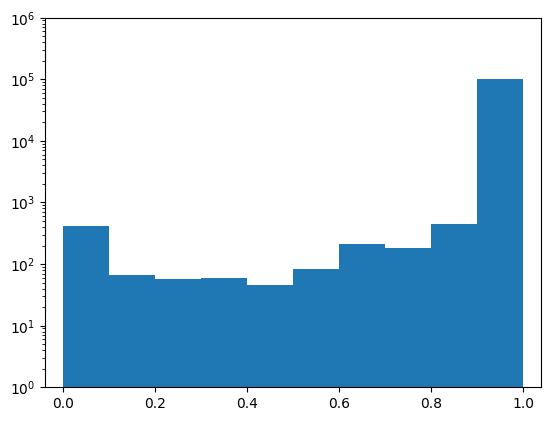

In [110]:
keys = urldata[urldata.label == "malicious"]

x = keys[['hostname_length',
       'path_length', 'fd_length', 'tld_length', 'count-', 'count@', 'count?',
       'count%', 'count.', 'count=', 'count-http','count-https', 'count-www', 'count-digits',
       'count-letters', 'count_dir', 'use_of_ip']]

key_prediction = rfc.predict_proba(x)
print(key_prediction)


plt.hist(key_prediction[:, 1], log=True)
# x1,x2,y1,y2 = plt.axis()  
plt.axis((x1,x2,1,1000000))

## Non-keys distribution

[[1.         0.        ]
 [1.         0.        ]
 [0.9794828  0.0205172 ]
 ...
 [0.98533176 0.01466824]
 [0.99722403 0.00277597]
 [1.         0.        ]]


(-0.03900000000000001, 1.039, 1.0, 1000000.0)

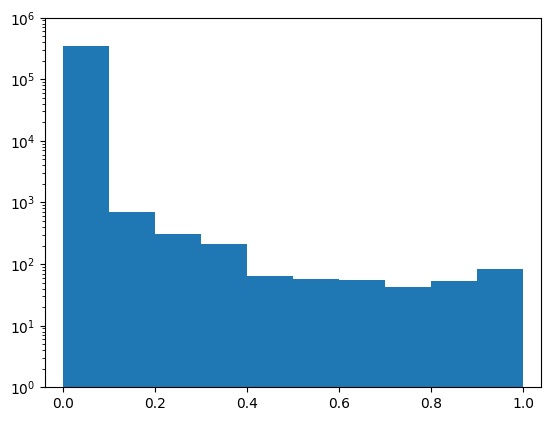

In [113]:
non_keys = urldata[urldata.label == "benign"]

x = non_keys[['hostname_length',
       'path_length', 'fd_length', 'tld_length', 'count-', 'count@', 'count?',
       'count%', 'count.', 'count=', 'count-http','count-https', 'count-www', 'count-digits',
       'count-letters', 'count_dir', 'use_of_ip']]

key_prediction = rfc.predict_proba(x)
print(key_prediction)


plt.hist(key_prediction[:, 1], log=True)
# x1,x2,y1,y2 = plt.axis()  
plt.axis((x1,x2,1,1000000))